# Libraries

In [1]:
## Useful libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import os
import copy
import pickle
from urllib.request import urlretrieve
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import TwoSlopeNorm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Additional input
import networkx as nx
from tqdm import tqdm
# !pip install torch_geometric
from torch_geometric.data import Data
# !pip install perlin-noise
from perlin_noise import PerlinNoise
import random
from loader import load_dataset
from datetime import datetime

from cycler import cycler
import seaborn as sns
import time

# Set the color scheme
sns.set_theme()
colors = ['#0076C2', '#EC6842', '#A50034', '#009B77', '#FFB81C', '#E03C31', '#6CC24A', '#EF60A3', '#0C2340', '#00B8C8', '#6F1D77']
plt.rcParams['axes.prop_cycle'] = cycler(color=colors)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from functions import *

# Data

In [2]:
data_folder = 'raw_datasets/'
train_dataset = 'DEM/'

In [3]:
dataset_folder = data_folder
n_sim = 80
start_sim = 1
dataset_name = 'grid'

datasets_folder = 'datasets'
if not os.path.exists(datasets_folder):
    os.makedirs(datasets_folder)
    
dataset_dir = datasets_folder + '/train'


##################### Use this code to create local pickle file #####################
#pyg_dataset = create_grid_dataset(dataset_folder, n_sim=n_sim)
#save_database(pyg_dataset, name=dataset_name, out_path=dataset_dir)

train_dataset = load_dataset(dataset_name=dataset_name, dataset_folder=dataset_dir)
test_dataset = load_dataset(dataset_name=dataset_name, dataset_folder=dataset_dir)

In [4]:
def normalize_dataset(dataset, scaler_DEM, scaler_WD):
    
    min_DEM, max_DEM = scaler_DEM.data_min_[0], scaler_DEM.data_max_[0]
    min_WD, max_WD = scaler_WD.data_min_[0], scaler_WD.data_max_[0]
    normalized_dataset = []

    for idx in range(len(dataset)):
        DEM = dataset[idx]['DEM']
        WD = dataset[idx]['WD']
        norm_DEM = (DEM - min_DEM) / (max_DEM - min_DEM)
        norm_WD = (WD - min_WD) / (max_WD - min_WD)

        DEM = norm_DEM.reshape(64,64)
        WD = norm_WD[:,0].reshape(64,64)
        
        temp_dict = {}
        temp_dict['Input'] = torch.stack((DEM, WD), dim=0)

        WD_transposed = norm_WD[:, 1:].reshape(64,64, -1)
        WD_transposed = WD_transposed.transpose(0, 2)
        WD_transposed = WD_transposed.transpose(1, 2)
        temp_dict['WD'] = WD_transposed
    
        normalized_dataset.append(temp_dict)
    
    return normalized_dataset

In [5]:
# Normalize the inputs and outputs using training dataset
scaler_DEM = MinMaxScaler() # Can store DEM, VX, VY as one 'input' Scaler
scaler_WD = MinMaxScaler()

for index in range(len(train_dataset)): # =80
    scaler_DEM.partial_fit(train_dataset[index]['DEM'].reshape(-1, 1).cpu())
    scaler_WD.partial_fit(train_dataset[index]['WD'].reshape(-1, 1).cpu())

normalized_train_dataset = normalize_dataset(train_dataset, scaler_DEM, scaler_WD)

In [6]:
# Split dataset into train, validation, and testing
train_percnt = 0.8
train_size = int(train_percnt * len(train_dataset))
val_size = len(train_dataset) - train_size
training_dataset, val_dataset = random_split(normalized_train_dataset, [train_size, val_size])

# Model

In [7]:
folder = "CNN_auto_regressive models/"
pre_trained_model = folder + "model_t48_lr0_0005_ep300.pth"

In [8]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, bias=False, batch_norm=True):
        super().__init__()

        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=bias)]
        if batch_norm:
            layers.append(nn.BatchNorm2d(num_features=out_channels))
        layers.append(nn.PReLU())
        layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=bias))

        self.cnnblock = nn.Sequential(*layers)

    def forward(self, x):
        return self.cnnblock(x)

class Encoder(nn.Module):
    def __init__(self, channels=[32, 64, 128], kernel_size=3, padding=1, bias=False, batch_norm=True):
        super().__init__()

        self.enc_blocks = nn.ModuleList([
            CNNBlock(channels[block], channels[block+1], kernel_size, padding, bias,
                     batch_norm=batch_norm)
            for block in range(len(channels)-1)]
            )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        outs = []
        for block in self.enc_blocks:
            x = block(x)
            outs.append(x)
            x = self.pool(x)
        return outs

class Decoder(nn.Module):
    def __init__(self, channels=[128, 64, 32], kernel_size=3, padding=1, bias=False, batch_norm=True):
        super().__init__()
        self.channels = channels
        self.upconvs = nn.ModuleList([
            nn.ConvTranspose2d(channels[block], channels[block+1], kernel_size=2, padding=0, stride=2)
            for block in range(len(channels)-1)]
            )
        self.dec_blocks = nn.ModuleList([
            CNNBlock(channels[block], channels[block+1], kernel_size, padding, bias,
                     batch_norm=batch_norm)
             for block in range(len(channels)-1)]
             )

    def forward(self, x, x_skips):
        for i in range(len(x_skips)):
            x = self.upconvs[i](x)
            x = torch.cat((x, x_skips[-(1+i)]), dim=1)
            x = self.dec_blocks[i](x)

        x = self.dec_blocks[-1](x)
        return x

class CNN(nn.Module):
    def __init__(self, node_features, out_dim=1, n_downsamples=3, initial_hid_dim=64, batch_norm=True,
                 bias=True):
        super(CNN, self).__init__()
        hidden_channels = [initial_hid_dim*2**i for i in range(n_downsamples)]
        encoder_channels = [node_features]+hidden_channels
        decoder_channels = list(reversed(hidden_channels))+[out_dim]

        self.encoder = Encoder(encoder_channels, kernel_size=3, padding=1,
                               bias=bias, batch_norm=batch_norm)
        self.decoder = Decoder(decoder_channels, kernel_size=3, padding=1,
                               bias=bias, batch_norm=batch_norm)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x[-1], x[:-1])
        x = nn.Sigmoid()(x)
        return x

node_features = 2
model = CNN(node_features=node_features, n_downsamples=4, initial_hid_dim=32,
            batch_norm=True, bias=True)

# Get losses

In [9]:
def get_errors(model, loader, device='cpu'):
    model.to(device)
    model.eval() # specifies that the model is in evaluation mode
    
    losses = []
    
    with torch.no_grad():
        for batch in loader:
            x = batch['Input']
            y = batch['WD']  # [:,:,:,1]

            # Model prediction
            preds = model(x)

            # MSE loss function
            loss = nn.MSELoss()(preds, y)
            losses.append(loss.cpu().detach())

    losses = np.array(losses)

    return losses

In [10]:
batch_size = 1
test_loader = DataLoader(normalized_train_dataset, batch_size=batch_size, shuffle=False)

In [11]:
# Model validation
test_loss = get_errors(model, test_loader, device=device)

C:\Users\Sjoer\anaconda3\envs\dsaie\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 96, 64, 64])) that is different to the input size (torch.Size([1, 1, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [12]:
print(test_loss)

[0.20662475 0.20874073 0.20482033 0.20168996 0.20662445 0.20608222
 0.20217575 0.20756046 0.20424677 0.20368242 0.20507228 0.20623876
 0.20726807 0.20629394 0.20117258 0.20479476 0.21015836 0.20542713
 0.20902763 0.20611246 0.20456345 0.20198588 0.20850496 0.20782447
 0.20701908 0.20293213 0.20549428 0.20237108 0.20477192 0.20292664
 0.20210664 0.2025456  0.2053383  0.20490561 0.20825188 0.20610905
 0.20206185 0.20445961 0.20448811 0.20743708 0.20274878 0.20117436
 0.20870028 0.2060564  0.20589279 0.20369458 0.20450906 0.20219958
 0.20340388 0.20286196 0.20531683 0.20164877 0.20902805 0.20226075
 0.2057605  0.20612778 0.20501782 0.20233418 0.21041967 0.20623322
 0.20538862 0.20263    0.20339762 0.20599206 0.2029771  0.20426865
 0.2051748  0.20854585 0.20189227 0.20295997 0.20480633 0.20614778
 0.2044375  0.2048121  0.20480894 0.20821738 0.2036364  0.20165335
 0.20238133 0.20507067]


# Visualize errors

(0.0, 20.0)

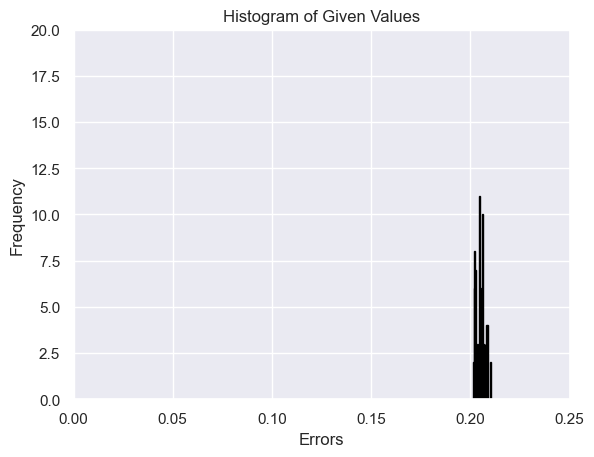

In [19]:
plt.hist(test_loss, bins=20, edgecolor='black')

plt.title('Histogram of Given Values')
plt.xlabel('Errors')
plt.ylabel('Frequency')

plt.xlim(0.000, 0.250)
plt.ylim(0, 20)

# Visualize

In [14]:
# select one sample
data_id = 70
x = normalized_train_dataset[data_id]['Input'].reshape(1, 2, 64, 64)

pred_WD = model(x).detach()
WD = normalized_train_dataset[data_id]['WD'][-1,:,:]
pred_last_WD = pred_WD[:,-1,:,:]


show_WD = WD.reshape(64,64)
show_pred_WD = pred_last_WD.reshape(64,64)

number_grids = 64

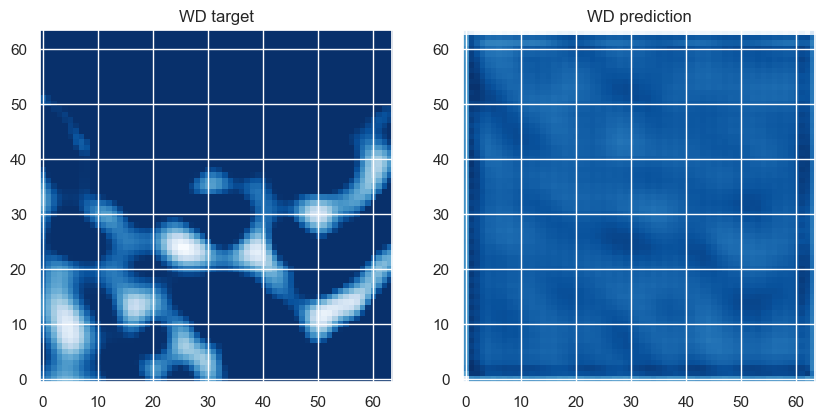

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(show_WD.reshape(number_grids,number_grids), cmap='Blues_r', origin='lower')
axs[0].set_title('WD target')

axs[1].imshow(show_pred_WD.reshape(number_grids,number_grids), cmap='Blues_r', origin='lower')
axs[1].set_title('WD prediction')
plt.show()